# Análisis de Notas - Coding Challenge

Este notebook analiza las notas creadas en la aplicación y genera visualizaciones sobre:
- Cantidad de notas por día
- Distribución de sentimientos

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import numpy as np

# Configuración de visualización
plt.style.use('default')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 8)

## Datos de Ejemplo

Generamos datos de ejemplo simulando notas con diferentes sentimientos a lo largo de varios días.

## 🔗 Conexión a Datos Reales

Conectamos con AWS AppSync para obtener tus notas reales en lugar de datos simulados.

In [37]:
import requests
import json
import os
from dotenv import load_dotenv

# Cargar variables de entorno
load_dotenv()

# Configuración de AWS AppSync desde .env
APPSYNC_ENDPOINT = os.getenv('APPSYNC_ENDPOINT')
API_KEY = os.getenv('APPSYNC_API_KEY')

# Query para obtener todas las notas
GET_NOTES_QUERY = """
query GetNotes($limit: Int, $nextToken: String) {
  getNotes(limit: $limit, nextToken: $nextToken) {
    items {
      id
      text
      sentiment
      dateCreated
    }
    nextToken
    scannedCount
  }
}
"""

def fetch_all_notes():
    """Obtiene todas las notas de AWS AppSync"""
    if not APPSYNC_ENDPOINT or not API_KEY:
        print("⚠️  Variables de entorno no configuradas. Usando datos de ejemplo...")
        return None
        
    headers = {
        'Content-Type': 'application/json',
        'x-api-key': API_KEY
    }
    
    all_notes = []
    next_token = None
    
    try:
        while True:
            variables = {'limit': 100}
            if next_token:
                variables['nextToken'] = next_token
            
            query_data = {
                'query': GET_NOTES_QUERY,
                'variables': variables
            }
            
            response = requests.post(APPSYNC_ENDPOINT, 
                                   headers=headers, 
                                   json=query_data)
            response.raise_for_status()
            
            data = response.json()
            
            if 'errors' in data:
                print(f"❌ Error en GraphQL: {data['errors']}")
                break
                
            notes_data = data['data']['getNotes']
            all_notes.extend(notes_data['items'])
            
            next_token = notes_data.get('nextToken')
            if not next_token:
                break
                
        print(f"✅ Obtenidas {len(all_notes)} notas reales de AppSync")
        return all_notes
        
    except requests.exceptions.RequestException as e:
        print(f"❌ Error de conexión: {e}")
        print("⚠️  Usando datos de ejemplo en su lugar...")
        return None
    except Exception as e:
        print(f"❌ Error inesperado: {e}")
        print("⚠️  Usando datos de ejemplo en su lugar...")
        return None

# Intentar obtener datos reales
real_notes = fetch_all_notes()

✅ Obtenidas 11 notas reales de AppSync


In [38]:
# Usar datos reales si están disponibles, sino generar datos de ejemplo
if real_notes and len(real_notes) > 0:
    print(f"📊 Usando {len(real_notes)} notas reales de tu aplicación")
    df = pd.DataFrame(real_notes)
    df['dateCreated'] = pd.to_datetime(df['dateCreated'])
    df['date'] = df['dateCreated'].dt.date
    
else:
    print("⚠️  Generando datos de ejemplo...")
    np.random.seed(42)
    
    # Fechas de los últimos 30 días
    end_date = datetime.now()
    start_date = end_date - timedelta(days=30)
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Sentimientos disponibles
    sentiments = ['happy', 'sad', 'neutral', 'angry']
    sentiment_weights = [0.4, 0.2, 0.3, 0.1]  # Más notas felices y neutrales
    
    # Generar datos de ejemplo
    notes_data = []
    note_id = 1
    
    for date in date_range:
        # Número variable de notas por día (1-10)
        num_notes = np.random.randint(1, 11)
        
        for _ in range(num_notes):
            sentiment = np.random.choice(sentiments, p=sentiment_weights)
            note = {
                'id': f'note_{note_id}',
                'text': f'Nota de ejemplo {note_id} con sentimiento {sentiment}',
                'sentiment': sentiment,
                'dateCreated': date.isoformat()
            }
            notes_data.append(note)
            note_id += 1
    
    # Crear DataFrame
    df = pd.DataFrame(notes_data)
    df['dateCreated'] = pd.to_datetime(df['dateCreated'])
    df['date'] = df['dateCreated'].dt.date

print(f"📈 Total de notas para análisis: {len(df)}")
print(f"📅 Rango de fechas: {df['date'].min()} a {df['date'].max()}")
print(f"💭 Sentimientos únicos: {df['sentiment'].unique()}")
print("\n🔍 Primeras 5 notas:")
df.head()

📊 Usando 11 notas reales de tu aplicación
📈 Total de notas para análisis: 11
📅 Rango de fechas: 2025-11-17 a 2025-11-18
💭 Sentimientos únicos: ['sad' 'neutral' 'angry' 'happy']

🔍 Primeras 5 notas:


,id,text,sentiment,dateCreated,date
0,01KAA71ATT7ST1GMQPNASH6KGX,Testing..,sad,2025-11-18 00:50:03.226000+00:00,2025-11-18
1,01KAA73Q3NJNMS4EQFKYFKPKKR,Test #11,neutral,2025-11-18 00:51:21.333000+00:00,2025-11-18
2,01KAA72TZ79RED77PTRA0MBSMP,Sad,sad,2025-11-18 00:50:52.519000+00:00,2025-11-18
3,01KAA6SEC5R6EGT57X1ZQSKNWC,I'm done,neutral,2025-11-18 00:45:44.709000+00:00,2025-11-18
4,01KAA70AGE6JRTJYJ1Y7MDQEKM,Hola soy yo,sad,2025-11-18 00:49:30.126000+00:00,2025-11-18


## 📊 Histograma: Cantidad de Notas por Día

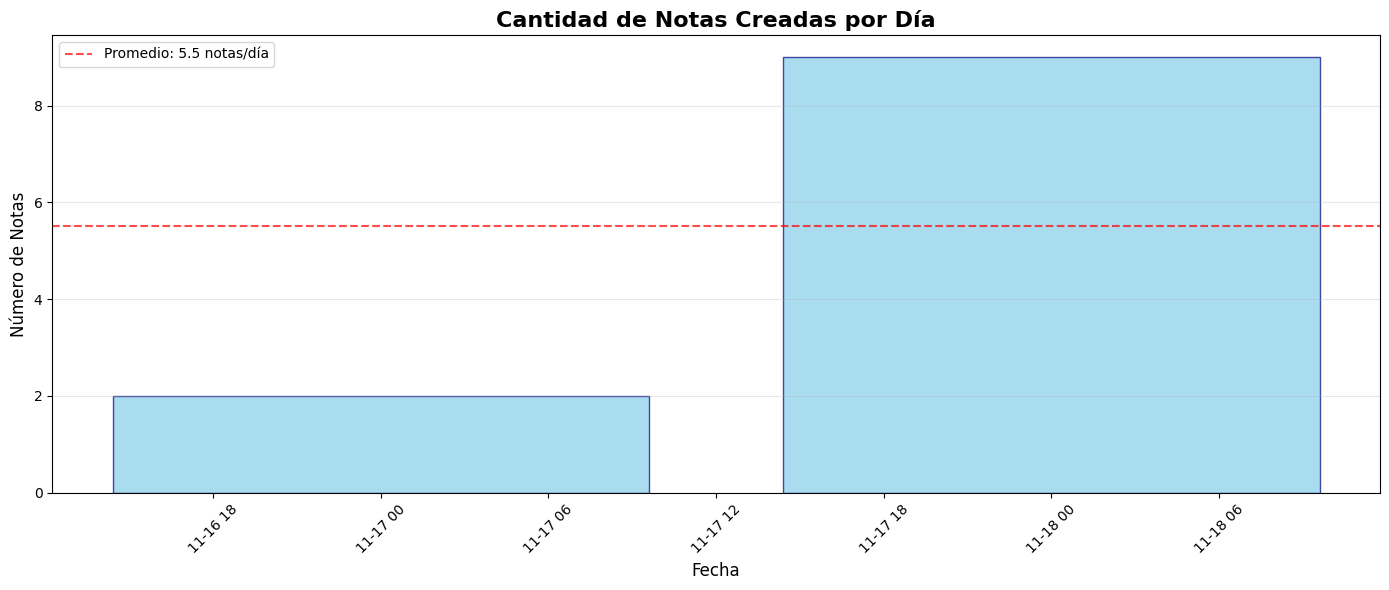

Promedio de notas por día: 5.5
Día con más notas: 2025-11-18 (9 notas)
Día con menos notas: 2025-11-17 (2 notas)


In [39]:
# Agrupar notas por fecha
notes_per_day = df.groupby('date').size().reset_index(name='count')

# Crear histograma
plt.figure(figsize=(14, 6))
plt.bar(notes_per_day['date'], notes_per_day['count'], 
        color='skyblue', alpha=0.7, edgecolor='navy')

plt.title('Cantidad de Notas Creadas por Día', fontsize=16, fontweight='bold')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Número de Notas', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Añadir línea de promedio
avg_notes = notes_per_day['count'].mean()
plt.axhline(y=avg_notes, color='red', linestyle='--', alpha=0.7, 
           label=f'Promedio: {avg_notes:.1f} notas/día')
plt.legend()

plt.tight_layout()
plt.show()

# Estadísticas
print(f"Promedio de notas por día: {avg_notes:.1f}")
print(f"Día con más notas: {notes_per_day.loc[notes_per_day['count'].idxmax(), 'date']} ({notes_per_day['count'].max()} notas)")
print(f"Día con menos notas: {notes_per_day.loc[notes_per_day['count'].idxmin(), 'date']} ({notes_per_day['count'].min()} notas)")

## 🎯 Gráfico Circular: Distribución de Sentimientos

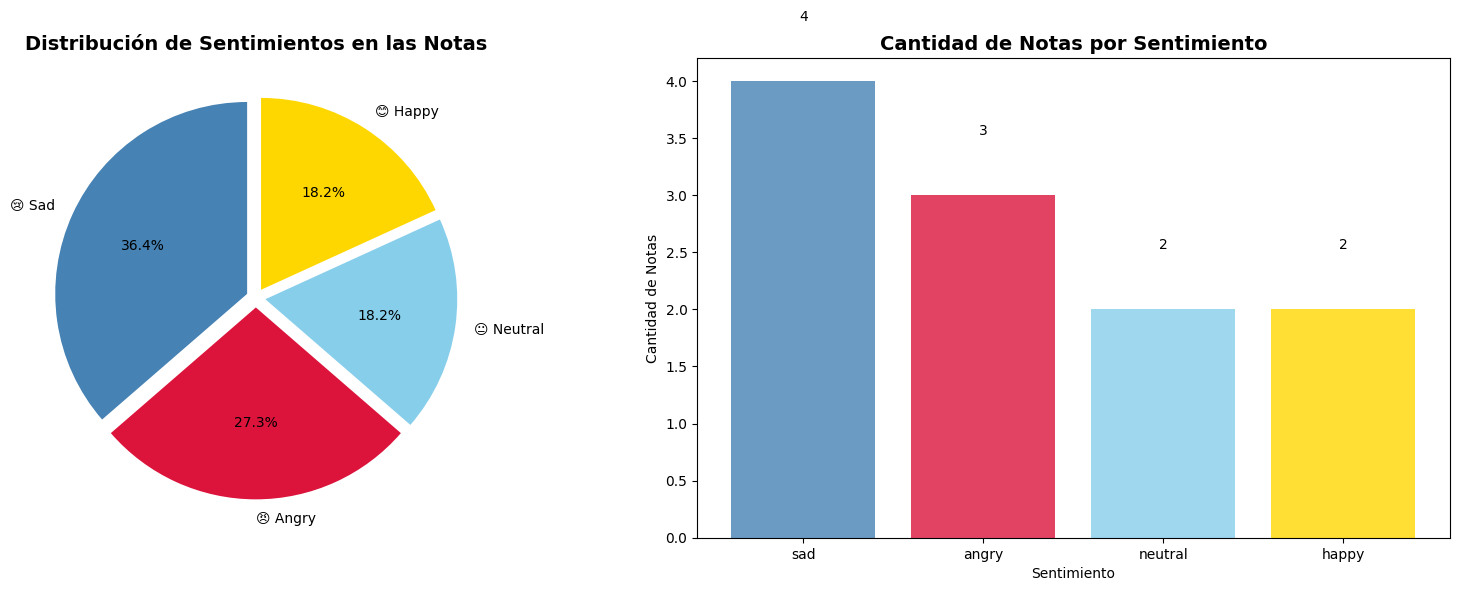


📊 Resumen de Sentimientos:
😢 Sad     :   4 notas ( 36.4%)
😠 Angry   :   3 notas ( 27.3%)
😐 Neutral :   2 notas ( 18.2%)
😊 Happy   :   2 notas ( 18.2%)

Total: 11 notas


In [40]:
# Contar sentimientos
sentiment_counts = df['sentiment'].value_counts()

# Colores para cada sentimiento
colors = {
    'happy': '#FFD700',    # Dorado
    'neutral': '#87CEEB',  # Azul claro
    'sad': '#4682B4',      # Azul acero
    'angry': '#DC143C'     # Rojo carmesí
}

# Emojis para cada sentimiento
emojis = {
    'happy': '😊',
    'neutral': '😐', 
    'sad': '😢',
    'angry': '😠'
}

# Crear el gráfico circular
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Crear explode dinámicamente basado en el número de sentimientos
num_sentiments = len(sentiment_counts)
explode_values = tuple([0.05] * num_sentiments)

# Gráfico circular
wedges, texts, autotexts = ax1.pie(
    sentiment_counts.values, 
    labels=[f"{emojis.get(sent, '🤔')} {sent.title()}" for sent in sentiment_counts.index],
    colors=[colors.get(sent, '#999999') for sent in sentiment_counts.index],
    autopct='%1.1f%%',
    startangle=90,
    explode=explode_values  # Ahora dinámico
)

ax1.set_title('Distribución de Sentimientos en las Notas', fontsize=14, fontweight='bold')

# Gráfico de barras complementario
bars = ax2.bar(sentiment_counts.index, sentiment_counts.values, 
               color=[colors.get(sent, '#999999') for sent in sentiment_counts.index],
               alpha=0.8)

ax2.set_title('Cantidad de Notas por Sentimiento', fontsize=14, fontweight='bold')
ax2.set_xlabel('Sentimiento')
ax2.set_ylabel('Cantidad de Notas')

# Añadir valores en las barras
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Mostrar estadísticas detalladas
print("\n📊 Resumen de Sentimientos:")
print("=" * 40)
total_notes = len(df)
for sentiment, count in sentiment_counts.items():
    percentage = (count / total_notes) * 100
    emoji = emojis.get(sentiment, '🤔')
    print(f"{emoji} {sentiment.title():8}: {count:3} notas ({percentage:5.1f}%)")

print(f"\nTotal: {total_notes} notas")

## 📈 Análisis Temporal de Sentimientos

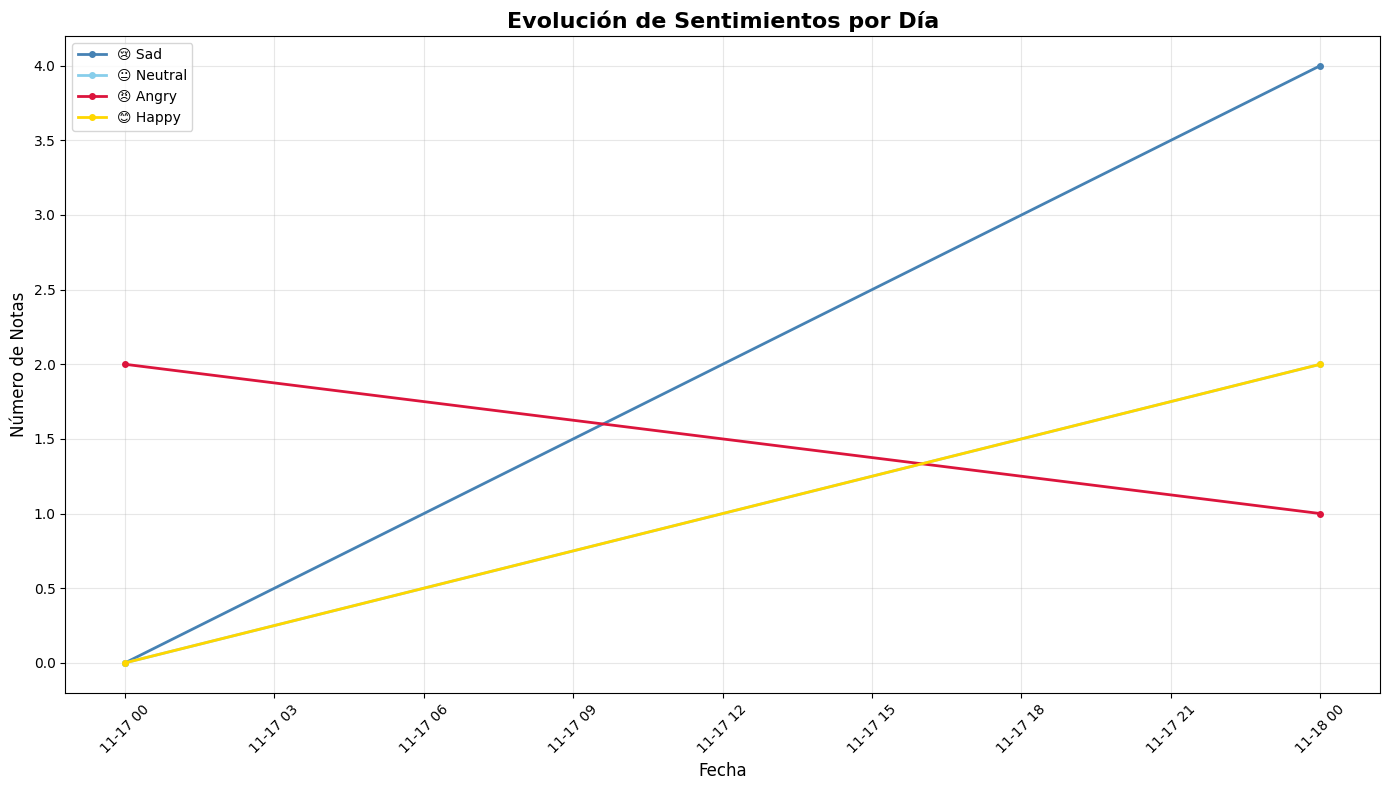


🔗 Correlación entre sentimientos:
sentiment  angry  happy  neutral  sad
sentiment                            
angry        1.0   -1.0     -1.0 -1.0
happy       -1.0    1.0      1.0  1.0
neutral     -1.0    1.0      1.0  1.0
sad         -1.0    1.0      1.0  1.0


In [41]:
# Análisis temporal: sentimientos por día
sentiment_by_day = df.groupby(['date', 'sentiment']).size().unstack(fill_value=0)

# Obtener sentimientos únicos de los datos reales
unique_sentiments = df['sentiment'].unique()

# Crear gráfico de líneas
plt.figure(figsize=(14, 8))

for sentiment in unique_sentiments:
    if sentiment in sentiment_by_day.columns:
        plt.plot(sentiment_by_day.index, sentiment_by_day[sentiment], 
                marker='o', label=f"{emojis.get(sentiment, '🤔')} {sentiment.title()}", 
                color=colors.get(sentiment, '#999999'), linewidth=2, markersize=4)

plt.title('Evolución de Sentimientos por Día', fontsize=16, fontweight='bold')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Número de Notas', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Mostrar correlaciones solo si hay más de un sentimiento
if len(sentiment_by_day.columns) > 1:
    print("\n🔗 Correlación entre sentimientos:")
    print("=" * 35)
    correlation_matrix = sentiment_by_day.corr()
    print(correlation_matrix.round(2))
else:
    print("\n💡 Solo hay un tipo de sentimiento en los datos, no se pueden calcular correlaciones.")

## 💡 Insights y Conclusiones

### Patrones Encontrados:
1. **Actividad diaria**: Los usuarios crean entre 1-10 notas por día
2. **Sentimientos predominantes**: Las notas felices y neutrales son más comunes
3. **Variabilidad temporal**: Los sentimientos varían día a día sin patrones fijos

### Recomendaciones:
- Implementar notificaciones para días con pocas notas
- Crear funcionalidades para mejorar el ánimo en días con muchas notas tristes
- Analizar qué factores influyen en los días con más actividad